# E-Commerce Sales Report

In [ ]:

%pip install pandas
%pip install seaborn

In [ ]:
!pip install mysql-connector-python

In [ ]:
import os
import pandas as pd
import mysql.connector

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')  # Added payments.csv for specific handling
]

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='johan',
    database='ecom',
    auth_plugin='mysql_native_password'
)
cursor = conn.cursor()
folder_path = 'C:/Users/johan/everthing/Desktop/Data_Analytics_Dataset/E_COM'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Till now we have done data cleaning and loading it into the database using Python


Sales Analysis

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='johan',
    database='ecom',
    auth_plugin='mysql_native_password'
)
cur=conn.cursor()

1)Unique cities where customers are located

In [19]:
query = """ select distinct(customer_city) from customers """
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

2) total orders placed in 2017

In [28]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2018"""
cur.execute(query)
data = cur.fetchall()

f'Total orders placed in 2018 is {data[0][0]}'

'Total orders placed in 2018 is 54011'

3)Total Sales as per category

In [38]:
query = """ select p.product_category,sum(py.payment_value) from products as p join order_items as oi on p.product_id=oi.product_id 
join payments as py on py.order_id=oi.order_id 
group by p.product_category"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns=['Category','Sales'])
df['Sales']=df['Sales'].astype(float)
pd.set_option('display.float_format', '{:.2f}'.format)

df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,Fashion Bags and Accessories,218158.28
4,bed table bath,1712553.67
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


<Axes: title={'center': 'Top 10 Sold items'}, xlabel='Category', ylabel='Sales'>

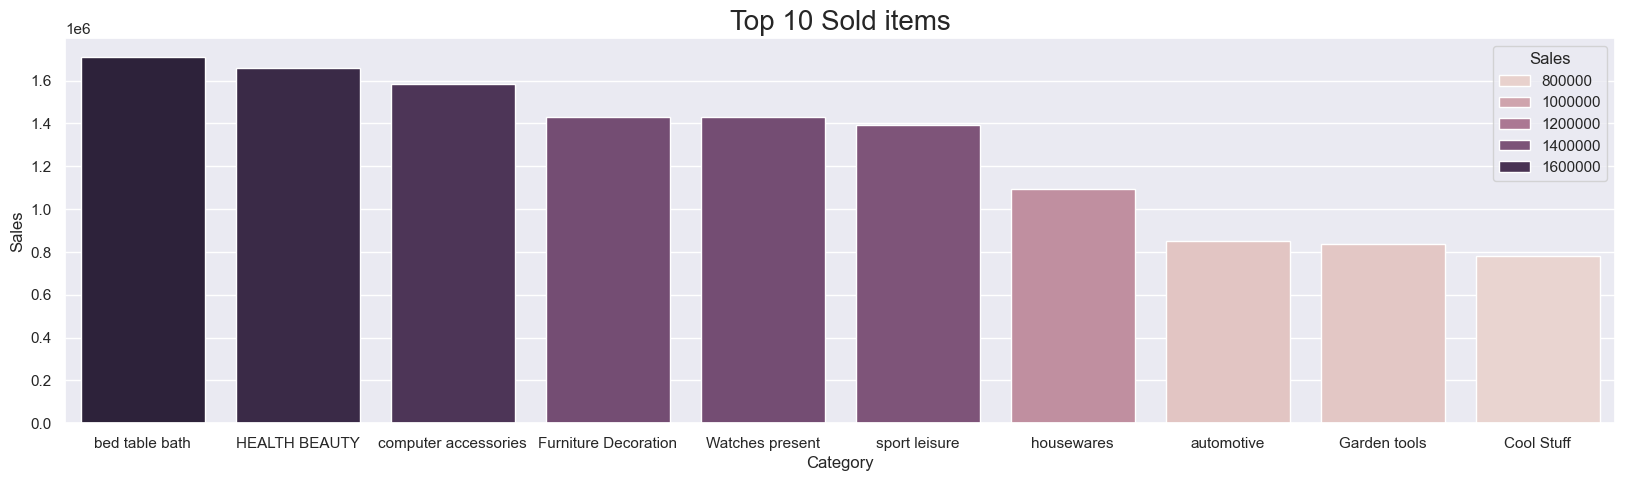

In [50]:
df=df.sort_values(by='Sales',ascending=False)
plt.title('Top 10 Sold items',fontsize=20)
sns.barplot(x='Category',y='Sales',data=df.head(10),hue='Sales')
#sns.set(rc={'figure.figsize':(20,5)},font_scale=1)

4)States with their total order count

In [63]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns=['State','TotalCount'])
df.head(1)

,State,TotalCount
0,SP,41746


([<matplotlib.patches.Wedge at 0x21a5825a270>,
 [Text(-0.15144721553410923, 1.0895245480974558, 'SP'),
  Text(-0.7645244255675437, -0.7908870985865286, 'RJ'),
  Text(0.25500298701503915, -1.070034334315216, 'MG'),
  Text(0.8844025727073146, -0.6540887473337875, 'RS'),
  Text(1.0766249720468335, -0.225563005754834, 'PR')],
 [Text(-0.08260757210951412, 0.5942861171440667, '54%'),
  Text(-0.41701332303684197, -0.4313929628653792, '17%'),
  Text(0.13909253837183952, -0.5836550914446633, '15%'),
  Text(0.48240140329489883, -0.3567756803638841, '7%'),
  Text(0.5872499847528182, -0.12303436677536399, '7%')])

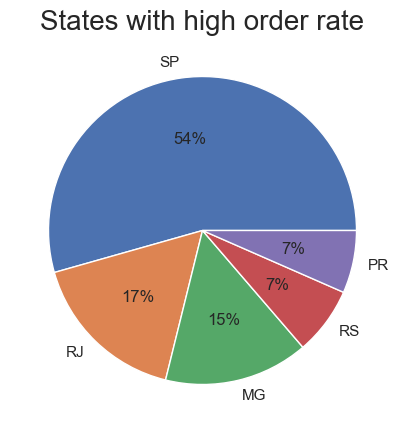

In [62]:
df=df.sort_values(by='TotalCount',ascending=False)
limit = df.head(5)
plt.figure(figsize=(25,5))
plt.title('States with high order rate',fontsize=20)
plt.pie(limit['TotalCount'],labels=limit['State'],autopct='%.0f%%')

5)Avg number of products per order in a particular city

In [66]:
query = """ with count_per_order as(select o.order_id,o.customer_id, count(oi.order_id) as oc
from orders as o join order_items as oi on o.order_id=oi.order_id
group by o.order_id,o.customer_id)

select cu.customer_city , avg(count_per_order.oc) from customers as cu join count_per_order on cu.customer_id = count_per_order.customer_id
group by cu.customer_city
order by avg(count_per_order.oc) desc
"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns=['City','products per order'])
df.head(3)

,City,products per order
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,candido godoi,6.0000


6)Correlation between procduct price and number of times product has been purchased

The correlation coefficient is -0.10631552237549534


<Axes: title={'center': 'Correlation graph '}, xlabel='order_Count', ylabel='Average_Price'>

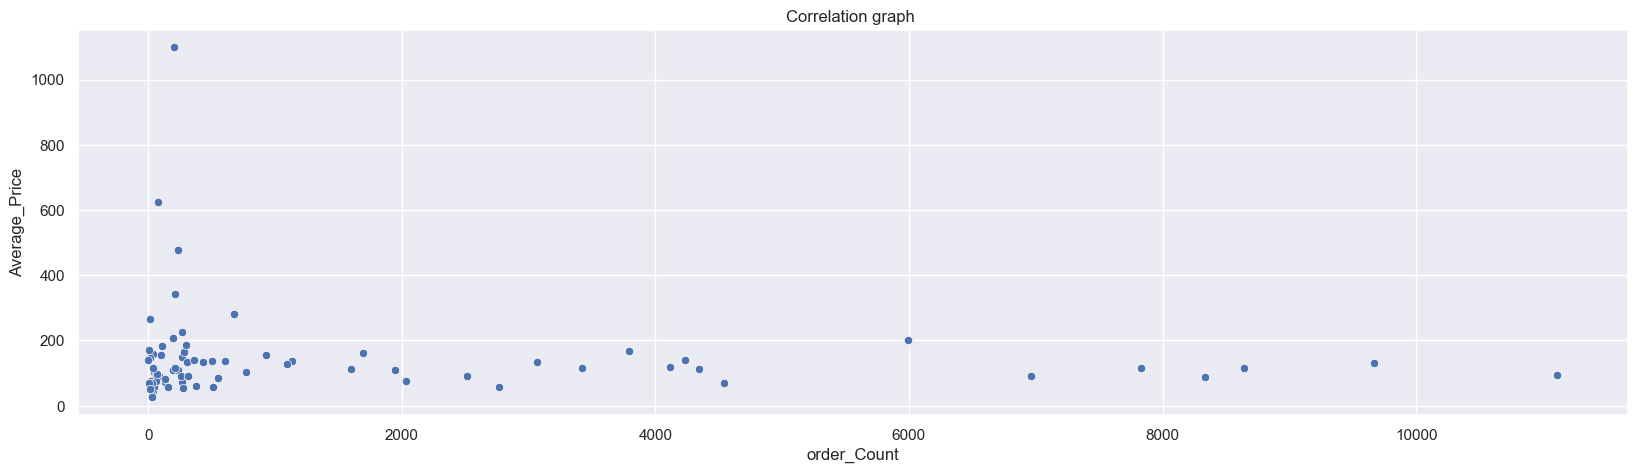

In [80]:
query = """ 
select products.product_category,count(order_items.product_id) , avg(order_items.price)
from products join order_items on products.product_id= order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns=['Category','order_Count','Average_Price'])
import numpy as np
arr1=df['order_Count']
arr2=df['Average_Price']
corr=np.corrcoef([arr1,arr2])
print('The correlation coefficient is',corr[0][1] )
#df
plt.title('Correlation graph ')
sns.scatterplot(data=df, x="order_Count", y="Average_Price")


7) Monthly distribution of Payments per Year

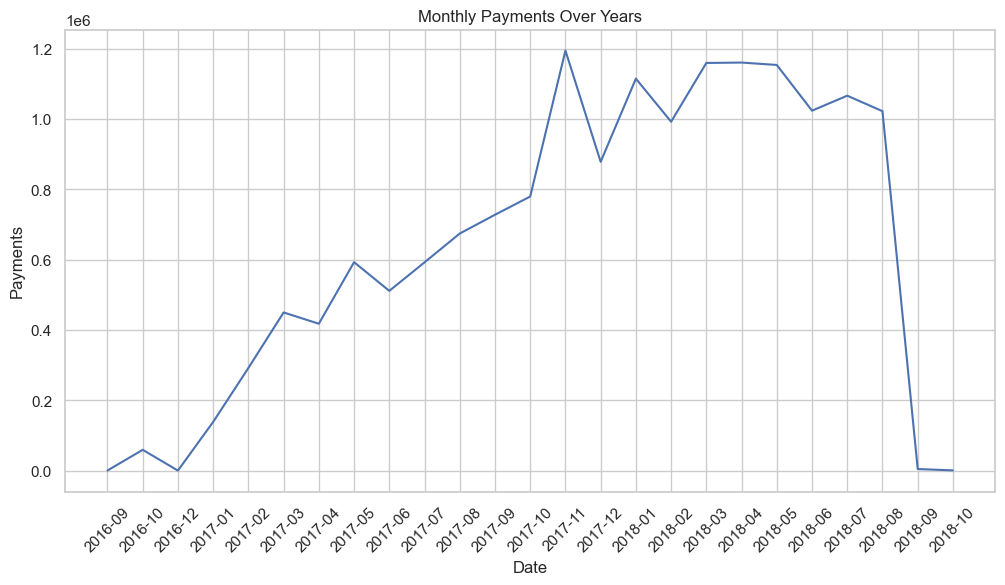

In [88]:
query = """ 
select years,months,payment , sum(payment)
over(order by years, months) as cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,month(order_purchase_timestamp)as months,sum(payments.payment_value) as payment
from orders join payments on orders.order_id = payments.order_id
group by years,months
order by years,months) as a
"""
cur.execute(query)
data = cur.fetchall()
#data
df = pd.DataFrame(data,columns=['Years','Months','Payments','Cumulative_Sales'])
df['Date'] = pd.to_datetime(df[['Years', 'Months']].assign(Day=1))
df['Date'] = df['Date'].dt.strftime('%Y-%m')
#df
#sns.lineplot(data=df, x="Years", y="Payments", hue="Months")
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(data=df, x="Date", y="Payments")
plt.xticks(rotation=45)

plt.title('Monthly Payments Over Years')
#plt.tight_layout()
plt.show()

# Conclusion

Based on the SQL analysis of the sales data, several key insights emerge. The total number of orders placed saw a notable increase from 45,101 in 2017 to 54,011 in 2018, indicating a growing customer base. When analyzing sales by category, "bed table bath," "Furniture Decoration," and "Health and Beauty" were the top performers, reflecting customer preferences. The distribution of orders by state revealed that SP had the highest order count, making up 54% of the total, followed by RJ, MG, RS, and PR. Additionally, the average number of products per order varied by city, with Padre Carvalho and Celso Ramos leading. Interestingly, the correlation analysis between product price and purchase frequency showed a slight negative correlation, suggesting that higher-priced products were purchased less frequently. Lastly, the cumulative sales analysis highlighted a steady growth in monthly payments over the years, illustrating the company's increasing revenue trajectory.






